# Phase planes Nai and Ko remim sanity check

In [1]:
### Importing packages and functions
import sys
import os
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
os.environ['AUTO_DIR'] = '/home/contreras//Documents/Auto4Servers/compute2/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
import autoutils
import auto

In [2]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [3]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [4]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [5]:
def saving_pdf_figure(fig,fig_name,md_dir,raster=False,tight=False):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    if raster:
        if raster>1:
            rast=raster
        else:
            rast=300
        if tight:
            ax.savefig(fig_name+'.png',dpi=rast, bbox_inches = 'tight',
    pad_inches = 0)
            fig.savefig(pdffig, format="pdf",dpi=rast, bbox_inches = 'tight',
    pad_inches = 0)
        else:
            ax.savefig(fig_name+'.png',dpi=rast)
            fig.savefig(pdffig, format="pdf",dpi=rast)
    else:
        if tight:
            ax.savefig(fig_name+'.png', bbox_inches = 'tight',
    pad_inches = 0)
            fig.savefig(pdffig, format="pdf", bbox_inches = 'tight',
    pad_inches = 0)

        else:
            ax.savefig(fig_name+'.png')
            fig.savefig(pdffig, format="pdf")

    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [6]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [7]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_Jacobian(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    return(J)

In [8]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto
def get_expressions(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    return var,rhs,spikecriterion,J
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000, int(1000.0/0.01))
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

# Defining setup for the continuations

### Defining neuron model

In [9]:
## Loading neuron model (file in the cfg folder)
model_name_p='MTM_W_sPNAs_Temp_proper_correcected_timescale'
model_name_p0='MTM_W_sPNAs_Temp_proper_snapshot_p0'
model_name_pp='MTM_W_sPNAs_Temp_proper_snapshot_pp'

### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap_p=generic_neuron_from_json(model_name_p+'.json',strIapp=strIapp)
neuron_snap_p0=generic_neuron_from_json(model_name_p0+'.json',strIapp=strIapp)
neuron_snap_pp=generic_neuron_from_json(model_name_pp+'.json',strIapp=strIapp)


In [10]:
### Check if parameters are the same in all models...
for ipar_s in neuron_snap_pp.p.keys():
    if ipar_s in neuron_snap_p.p.keys():
        if neuron_snap_pp.p[ipar_s]!=neuron_snap_p.p[ipar_s]:
            print(ipar_s+' is different in big model')
    else:
        print(ipar_s+' not in big model')
        
for ipar_s in neuron_snap_pp.p.keys():
    if ipar_s in neuron_snap_p0.p.keys():
        if neuron_snap_pp.p[ipar_s]!=neuron_snap_p0.p[ipar_s]:
            print(ipar_s+' is different in pump0 model')
    else:
        print(ipar_s+' not in pump0 model')
        
#         neuron.p[ipar_s]=ref_sim.c_neuron.p[ipar_s]

K_o not in big model
Na_i not in big model
K_i not in big model


In [11]:
# Function to adjust Jmat dimensions
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])

    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat

from sympy.utilities.lambdify import lambdify
from numpy import linalg as LA


In [12]:
xr0=25.;xr1=95.;yr0=-100.;yr1=-35.;res_vect_field=50
nx=res_vect_field
ny=res_vect_field
n_neurons=nx*ny
x0 = np.linspace(xr0, xr1, res_vect_field)
y0 = np.linspace(yr0, yr1, res_vect_field)
R=8314.4
T=293.15
F=96484.6
K_i=150.0
Na_o=140.0
x=Na_o/np.exp(x0*F/(R*T))
y=np.exp(y0*F/(R*T))*K_i
m_discrete_pars_vectfield=np.vstack(np.meshgrid(x,y)).reshape(2,-1)


In [16]:
dir_sims='./Data/'
model_name_p_fst='MTM_W_sPNAs_Temp_proper'
name='Bif_frozen_'+model_name_p_fst+'_uniform_nernst_vect_field'
f=open(dir_sims+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)



In [17]:
one_sim_s=d_save_sim['s_results']
m_discrete_pars_vectfield=d_save_sim['vect_field_pos']
t_I_app_specf=d_save_sim['t_iapp_specf']
a_lc=d_save_sim['Dyn_Sys_Properties']['e_limit_cycle']
a_un=d_save_sim['Dyn_Sys_Properties']['e_saddle']
a_sn=d_save_sim['Dyn_Sys_Properties']['e_stable']
a_lc_v=d_save_sim['Dyn_Sys_Properties']['limit_cycle']
a_un_v=d_save_sim['Dyn_Sys_Properties']['saddle']
a_sn_v=d_save_sim['Dyn_Sys_Properties']['stable']
a_hf_v=d_save_sim['Dyn_Sys_Properties']['hopf']

I_app=1.0


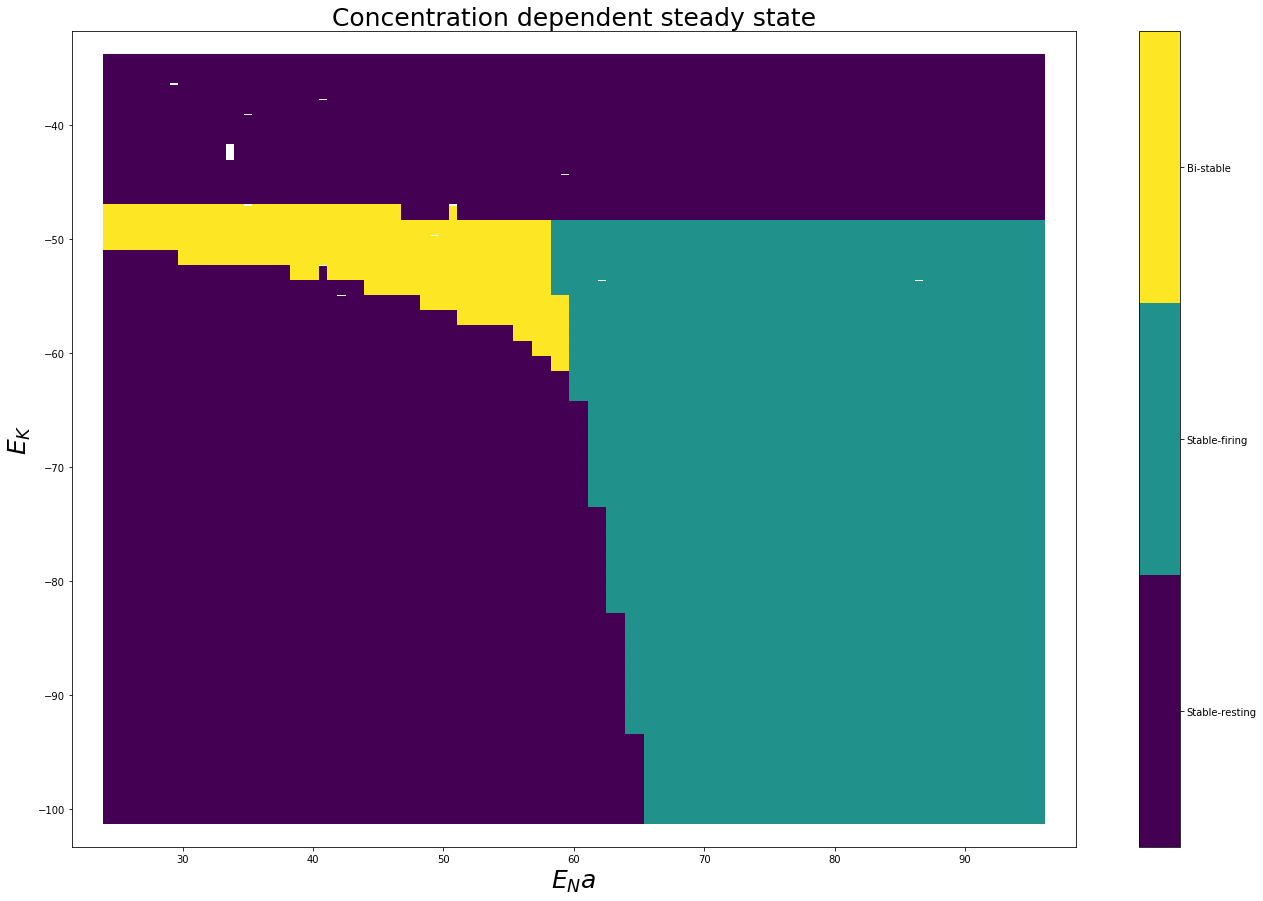

In [18]:
ii_t_iapp=3
php_descpt=[]
x_E_Na=[]
x_E_K=[]
for ii_neurons in range(n_neurons):
    if len(a_un[ii_neurons])==len(t_I_app_specf):
        Na_i=m_discrete_pars_vectfield[0][ii_neurons]
        x_E_Na.append(R*T/F*np.log(Na_o/Na_i))
        K_o=m_discrete_pars_vectfield[1][ii_neurons]
        x_E_K.append(R*T/F*np.log(K_o/K_i))
        ###### descpt=0 Uni-stable-silent: means that there is one one stable fixed point on the phase phase Plane
        ###### descpt=1 Uni-stable-spiking: means that there is one one stable orbit on phase Plane
        ###### descpt=2 Bi-stable: means that there is a stable fixed point and a stable orbit on phase Plane
        if a_lc[ii_neurons][ii_t_iapp]==0.0 and a_sn[ii_neurons][ii_t_iapp]>0.0:
            descpt=0
        if a_lc[ii_neurons][ii_t_iapp]>0.0 and a_sn[ii_neurons][ii_t_iapp]==0.0:
            descpt=1
        if a_lc[ii_neurons][ii_t_iapp]>0.0 and a_sn[ii_neurons][ii_t_iapp]>0.0:
            descpt=2
        if a_lc[ii_neurons][ii_t_iapp]==0.0 and a_sn[ii_neurons][ii_t_iapp]==0.0:
            descpt=1
        php_descpt.append(descpt)



fig_height=10
fig_wide=15
size_title_font=30
size_axis_font=25

fig,ax= plt.subplots(facecolor="1",figsize=(fig_wide*1.5,fig_height*1.5))

ax.set_xlabel(r'$E_Na$',fontsize=size_axis_font)
ax.set_ylabel(r'$E_K$',fontsize=size_axis_font)
ax.set_title('Concentration dependent steady state',fontsize=size_axis_font)
cmap2=matplotlib.cm.get_cmap('viridis')
# cmap2=viridis
bounds2 = [-0.5,0.5,1.5, 2.5]
norm2 = matplotlib.colors.BoundaryNorm(bounds2, cmap2.N)
TICKS2 = [0,1,2]
# p = ax.scatter(x_E_Na, x_E_K,c=np.array(x_php), cmap=cmap2, s=1000,marker='s', edgecolors='none')
p = ax.scatter(x_E_Na, x_E_K,c=np.array(php_descpt), cmap=cmap2, s=350*(1.5**2),marker='s')
# locatory1 = MaxNLocator(nbins=3) # with 3 bins you will have 4 ticks
# ax.yaxis.set_major_locator(locatory1)
# locatory2 = MaxNLocator(nbins=3)
# ax.xaxis.set_major_locator(locatory2)
# cb0=plt.colorbar(p, cmap=cmap2, norm=norm2, boundaries=bounds2, ticks=TICKS2, orientation="horizontal", pad=0.2)
# cb0=plt.colorbar(p, cmap=cmap2, norm=norm2, boundaries=bounds2, ticks=TICKS2)
cb0=plt.colorbar(p, cmap=cmap2, norm=norm2, boundaries=bounds2, ticks=TICKS2)
cb0.set_ticklabels(['Stable-resting','Stable-firing','Bi-stable'])
print('I_app='+str(t_I_app_specf[ii_t_iapp]))
fig.show()

In [19]:
K_o_ini_v=[8.0,8.0,8.0,8.0,12.0,17.0]
Na_i_ini_v=[14.0,12.0,9.0,7.0,7.0,10.0]
v_ini_v=[-70.0,-70.0,-70.0,-70.0,-70.0,-70.0]
K_i_ini=150.71
dir_folder='/groups/susanne/Susana/Simulations/' 

ii_t_iapp=3
n_mean=t_I_app_specf[ii_t_iapp]
n_amp=1.0

s_model_abrev=model_name_p
remim_str='02'
for ii_inis in range(len(v_ini_v)):
    v_ini=v_ini_v[ii_inis]
    K_o_ini=K_o_ini_v[ii_inis]
    Na_i_ini=Na_i_ini_v[ii_inis]
    
    file_n='Trace_'+s_model_abrev+'_Imean_'+str(abs(int(n_mean)))+'_Iamp_'+str(abs(int(n_amp)))+'_Nai0_'+str(Na_i_ini)+'_Ki0_'+str(K_i_ini)+'_Ko0_'+str(K_o_ini)+'_data_'+'replicating2020_origPars_v2remim_'+remim_str  

#     name='SIM_completeModel_w_NaKPhaseInfo_'+model_name_p+'_lengthSim_'+str(int(time_stim))+'_IniConds_Nai_'+str(int(Na_i_ini))+'_Ko_'+str(int(K_o_ini))+'_nmean_'+str(int(n_mean))+'_sig_'+str(int(sigma_v[0]))
    
    if os.path.isfile(dir_folder+file_n+'.pkl'):
        print(file_n+' existss')
    else:
        print(file_n+' doesnt exist!!! :(')

Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_14.0_Ki0_150.71_Ko0_8.0_data_replicating2020_origPars_v2remim_02 existss
Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_12.0_Ki0_150.71_Ko0_8.0_data_replicating2020_origPars_v2remim_02 existss
Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_9.0_Ki0_150.71_Ko0_8.0_data_replicating2020_origPars_v2remim_02 existss
Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_7.0_Ki0_150.71_Ko0_8.0_data_replicating2020_origPars_v2remim_02 existss
Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_7.0_Ki0_150.71_Ko0_12.0_data_replicating2020_origPars_v2remim_02 existss
Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_10.0_Ki0_150.71_Ko0_17.0_data_replicating2020_origPars_v2remim_02 existss


Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_14.0_Ki0_150.71_Ko0_8.0_data_replicating2020_origPars_v2remim_02  Exists..already there :D...
Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_12.0_Ki0_150.71_Ko0_8.0_data_replicating2020_origPars_v2remim_02  Exists..already there :D...
Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_9.0_Ki0_150.71_Ko0_8.0_data_replicating2020_origPars_v2remim_02  Exists..already there :D...
Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_7.0_Ki0_150.71_Ko0_8.0_data_replicating2020_origPars_v2remim_02  Exists..already there :D...
Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_7.0_Ki0_150.71_Ko0_12.0_data_replicating2020_origPars_v2remim_02  Exists..already there :D...
Trace_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_10.0_Ki0_150.71_Ko0_17.0_data_replicating2020_origPars_v2remim_02  Exists..already there :D...
I_app

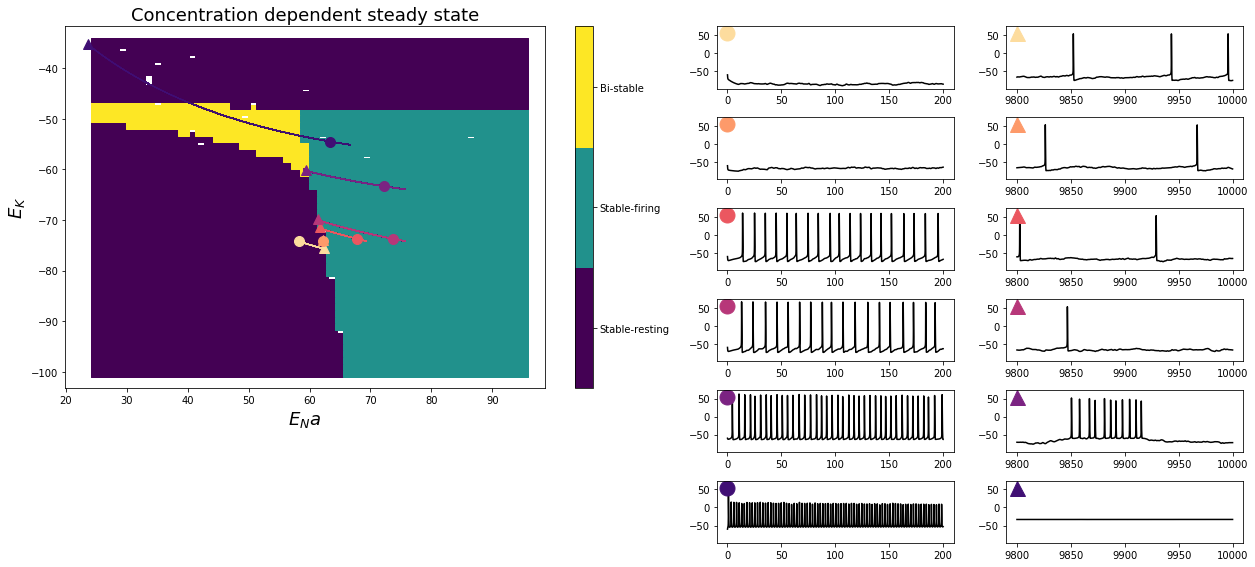

In [20]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

php_descpt=[]
x_E_Na=[]
x_E_K=[]
for ii_neurons in range(n_neurons):
    if len(a_un[ii_neurons])==len(t_I_app_specf):
        Na_i=m_discrete_pars_vectfield[0][ii_neurons]
        x_E_Na.append(R*T/F*np.log(Na_o/Na_i))
        K_o=m_discrete_pars_vectfield[1][ii_neurons]
        x_E_K.append(R*T/F*np.log(K_o/K_i))
        ###### descpt=0 Uni-stable-silent: means that there is one one stable fixed point on the phase phase Plane
        ###### descpt=1 Uni-stable-spiking: means that there is one one stable orbit on phase Plane
        ###### descpt=2 Bi-stable: means that there is a stable fixed point and a stable orbit on phase Plane
        if a_lc[ii_neurons][ii_t_iapp]==0.0 and a_sn[ii_neurons][ii_t_iapp]>0.0:
            descpt=0
        if a_lc[ii_neurons][ii_t_iapp]>0.0 and a_sn[ii_neurons][ii_t_iapp]==0.0:
            descpt=1
        if a_lc[ii_neurons][ii_t_iapp]>0.0 and a_sn[ii_neurons][ii_t_iapp]>0.0:
            descpt=2
        if a_lc[ii_neurons][ii_t_iapp]==0.0 and a_sn[ii_neurons][ii_t_iapp]==0.0:
            descpt=np.nan
        php_descpt.append(descpt)
    else:
        x_E_Na.append(np.nan)
        x_E_K.append(np.nan)
        php_descpt.append(np.nan)



# time_stim=900000.0
sigma_v=[n_amp,0.0,0.0,0.0,0.0,0.0,0.0]
        

fig_height=10
fig_wide=25
size_title_font=30
size_axis_font=25


n_splts=int(len(v_ini_v)/4)
n_splts=int(len(v_ini_v))
size_axis_font=18
fig = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))

col_num=58
fact_nsplts=10
width_nsplts=7

ax_st=[]
ax_fn=[]
for ii_ini in range(len(v_ini_v[::int(len(v_ini_v)/n_splts)])):
    if ii_ini>0:
        ax_st.append(plt.subplot2grid((fact_nsplts*(n_splts),col_num), (ii_ini*fact_nsplts,int(col_num/2-2)), colspan=int(col_num/4-4),rowspan=width_nsplts,sharex=ax_st[0],sharey=ax_st[0]))
        ax_fn.append(plt.subplot2grid((fact_nsplts*(n_splts),col_num), (ii_ini*fact_nsplts,int(col_num/2-2)+int(col_num/4-2)), colspan=int(col_num/4-4),rowspan=width_nsplts,sharex=ax_fn[0],sharey=ax_st[0]))

    else:
        ax_st.append(plt.subplot2grid((fact_nsplts*(n_splts),col_num), (ii_ini*fact_nsplts,int(col_num/2-2)), colspan=int(col_num/4-4),rowspan=width_nsplts))
        ax_fn.append(plt.subplot2grid((fact_nsplts*(n_splts),col_num), (ii_ini*fact_nsplts,int(col_num/2-2)+int(col_num/4-2)), colspan=int(col_num/4-4),rowspan=width_nsplts,sharey=ax_st[0]))



## Summary continuation..
axpl = plt.subplot2grid((fact_nsplts*(n_splts),col_num), (0, 0), colspan=int(col_num/2-4),rowspan=int(fact_nsplts*(n_splts)/1.5))





axpl.set_xlabel(r'$E_Na$',fontsize=size_axis_font)
axpl.set_ylabel(r'$E_K$',fontsize=size_axis_font)
axpl.set_title('Concentration dependent steady state',fontsize=size_axis_font)
cmap2=matplotlib.cm.get_cmap('viridis')
bounds2 = [-0.5,0.5,1.5, 2.5]
norm2 = matplotlib.colors.BoundaryNorm(bounds2, cmap2.N)
TICKS2 = [0,1,2]
p = axpl.scatter(x_E_Na, x_E_K,c=np.array(php_descpt), cmap=cmap2, s=50*(1.5**2),marker='s')
cb0=plt.colorbar(p, cmap=cmap2, norm=norm2, boundaries=bounds2, ticks=TICKS2)
cb0.set_ticklabels(['Stable-resting','Stable-firing','Bi-stable'])

cmap=plt.get_cmap('magma')
colors=iter(cmap(np.linspace(1,0,n_splts*2+3)))


ii_ini=0

for ii_inis in range(len(v_ini_v)):
    v_ini=v_ini_v[ii_inis]
    K_o_ini=K_o_ini_v[ii_inis]
    Na_i_ini=Na_i_ini_v[ii_inis]
    colorii=next(colors)
    colorii=next(colors)
    
    file_n='Trace_'+s_model_abrev+'_Imean_'+str(abs(int(n_mean)))+'_Iamp_'+str(abs(int(n_amp)))+'_Nai0_'+str(Na_i_ini)+'_Ki0_'+str(K_i_ini)+'_Ko0_'+str(K_o_ini)+'_data_'+'replicating2020_origPars_v2remim_'+remim_str  

    if os.path.isfile(dir_folder+file_n+'.pkl'):
        with open(dir_folder+file_n+'.pkl', 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            d_save_sim_ii = u.load()

        if len (d_save_sim_ii['v_sim_Nernst'])==0:
            RTF=d_save_sim_ii['d_parameters']['R']*d_save_sim_ii['d_parameters']['T']/d_save_sim_ii['d_parameters']['F']
            Na_o=d_save_sim_ii['d_parameters']['Na_o']
            Na_v=d_save_sim_ii['v_sim_state_vars'][[ii for ii in range(len(d_save_sim_ii['s_sim_state_vars'])) if d_save_sim_ii['s_sim_state_vars'][ii]=='Na_i'][0]]
            Ko_v=d_save_sim_ii['v_sim_state_vars'][[ii for ii in range(len(d_save_sim_ii['s_sim_state_vars'])) if d_save_sim_ii['s_sim_state_vars'][ii]=='K_o'][0]]
            Ki_v=d_save_sim_ii['v_sim_state_vars'][[ii for ii in range(len(d_save_sim_ii['s_sim_state_vars'])) if d_save_sim_ii['s_sim_state_vars'][ii]=='K_i'][0]]
            x_E_Na_v=RTF*np.log(Na_o/Na_v)
            x_E_K_v=RTF*np.log(Ko_v/Ki_v)
        else:
            x_E_K_v=d_save_sim_ii['v_sim_Nernst'][[ii for ii in range(len(d_save_sim_ii['s_sim_Nernst'])) if d_save_sim_ii['s_sim_Nernst'][ii]=='E_K'][0]]
            x_E_Na_v=d_save_sim_ii['v_sim_Nernst'][[ii for ii in range(len(d_save_sim_ii['s_sim_Nernst'])) if d_save_sim_ii['s_sim_Nernst'][ii]=='E_Na'][0]]

        kv=x_E_K_v[::10][:-1]
        nav=x_E_Na_v[::10][:-1]

        dk=kv[1:]-kv[:-1]
        dna=nav[1:]-nav[:-1]

        axpl.quiver(nav[::5], kv[::5], dk[::5], dna[::5],color=colorii, scale_units='xy', angles='xy', scale=1.0, rasterized=True)
        tv=d_save_sim_ii['v_sim_state_vars'][[ii for ii in range(len(d_save_sim_ii['s_sim_state_vars'])) if d_save_sim_ii['s_sim_state_vars'][ii]=='t'][0]]
        x_v=d_save_sim_ii['v_sim_state_vars'][[ii for ii in range(len(d_save_sim_ii['s_sim_state_vars'])) if d_save_sim_ii['s_sim_state_vars'][ii]=='v'][0]]

        tst=200.0
        tfn=tv[-1]-tst
#         ax.plot(x_E_Na_v[100],x_E_K_v[100],linewidth=5,color='k')
        axpl.plot(x_E_Na_v[tv>=tst][0],x_E_K_v[tv>=tst][0],'o',markersize=10,color=colorii)
        axpl.plot(x_E_Na_v[tv>=tfn][0],x_E_K_v[tv>=tfn][0],'^',markersize=10,color=colorii)
        
        ax_st[ii_ini].plot(tv[tv<=tst],x_v[tv<=tst],color='k', rasterized=True)
        ax_st[ii_ini].plot(tv[tv<=tst][0],55,'o',markersize=15,color=colorii)
        
        ax_fn[ii_ini].plot(tv[tv>=tfn],x_v[tv>=tfn],color='k', rasterized=True)
        ax_fn[ii_ini].plot(tv[tv>=tfn][0],55,'^',markersize=15,color=colorii)
        ii_ini+=1
        print(file_n+'  Exists..already there :D...' )
    else:
        print(file_n+'  Doesnt exist...' )

            
            
print('I_app='+str(t_I_app_specf[ii_t_iapp]))

fig.show()

# The next is to make the plot nicer

In [21]:
from scipy import interpolate

php_descpt=[]
x_E_Na=[]
x_E_K=[]
for ii_neurons in range(n_neurons):
    if len(a_un[ii_neurons])==len(t_I_app_specf):
        Na_i=m_discrete_pars_vectfield[0][ii_neurons]
        x_E_Na.append(R*T/F*np.log(Na_o/Na_i))
        K_o=m_discrete_pars_vectfield[1][ii_neurons]
        x_E_K.append(R*T/F*np.log(K_o/K_i))
        ###### descpt=0 Uni-stable-silent: means that there is one one stable fixed point on the phase phase Plane
        ###### descpt=1 Uni-stable-spiking: means that there is one one stable orbit on phase Plane
        ###### descpt=2 Bi-stable: means that there is a stable fixed point and a stable orbit on phase Plane
        if a_lc[ii_neurons][ii_t_iapp]==0.0 and a_sn[ii_neurons][ii_t_iapp]>0.0:
            descpt=0
        if a_lc[ii_neurons][ii_t_iapp]>0.0 and a_sn[ii_neurons][ii_t_iapp]==0.0:
            descpt=1
        if a_lc[ii_neurons][ii_t_iapp]>0.0 and a_sn[ii_neurons][ii_t_iapp]>0.0:
            descpt=2
        if a_lc[ii_neurons][ii_t_iapp]==0.0 and a_sn[ii_neurons][ii_t_iapp]==0.0:
            descpt=1.0
        php_descpt.append(descpt)

        
f = interpolate.interp2d(np.array(x_E_Na)[~np.isnan(x_E_Na)], np.array(x_E_K)[~np.isnan(x_E_K)], php_descpt, kind='cubic')

/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=44,47 m=2487 fp=0.006452 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [22]:
xv, yv = np.meshgrid(np.unique(np.array(x_E_Na)[~np.isnan(x_E_Na)]), np.unique(np.array(x_E_K)[~np.isnan(x_E_K)]), sparse=False)

In [23]:
xv, yv = np.meshgrid(np.unique(np.array(x_E_Na)[~np.isnan(x_E_Na)]), np.unique(np.array(x_E_K)[~np.isnan(x_E_K)]), sparse=False)
zv = np.zeros(np.shape(xv))

for ii in range(np.shape(xv)[0]):
    for jj in range(np.shape(xv)[1]):
        zv[ii,jj]=f(xv[ii,jj],yv[ii,jj])
        if zv[ii,jj]<0.5:
            zv[ii,jj]=0.0
        if zv[ii,jj]<1.5 and zv[ii,jj]>0.5:
            zv[ii,jj]=1.0
        if zv[ii,jj]>1.5:
            zv[ii,jj]=2.0

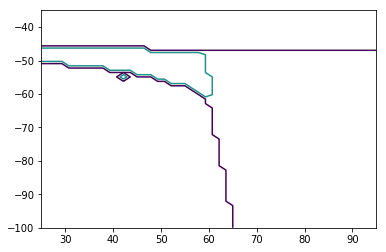

In [24]:
levels = np.arange(0.0, 0.99, 1.99)
h = plt.contour(xv,yv,zv,1)
plt.show()

p = h.collections[1].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]

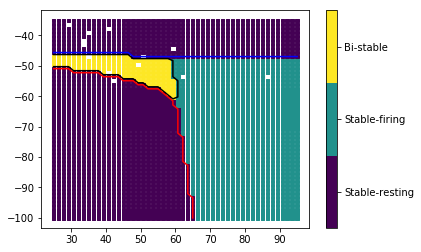

In [25]:
cmap2=matplotlib.cm.get_cmap('viridis')
bounds2 = [-0.5,0.5,1.5, 2.5]
norm2 = matplotlib.colors.BoundaryNorm(bounds2, cmap2.N)
TICKS2 = [0,1,2]
p = plt.scatter(x_E_Na, x_E_K,c=np.array(php_descpt), cmap=cmap2, s=5*(1.5**2),marker='s')
cb0=plt.colorbar(p, cmap=cmap2, norm=norm2, boundaries=bounds2, ticks=TICKS2)
cb0.set_ticklabels(['Stable-resting','Stable-firing','Bi-stable'])

p = h.collections[1].get_paths()[0]
v = p.vertices
xb = np.array(v[:,0])
yb = np.array(v[:,1])
plt.plot(xb,yb,color='k')

p = h.collections[0].get_paths()[0]
v = p.vertices
xlc = np.array(v[:,0])
ylc = np.array(v[:,1])
plt.plot(xlc,ylc,color='r')

p = h.collections[0].get_paths()[1]
v = p.vertices
xhf = np.array(v[:,0])
yhf = np.array(v[:,1])
plt.plot(xhf,yhf,color='b')

In [26]:
c=0
ii_failed=[]
c_uf=0
for i in x_E_Na:
    if np.isnan(i):
        K_o=m_discrete_pars_vectfield[1][c];Na_i=m_discrete_pars_vectfield[0][c]
        ii_failed.append(c)
        print([K_o,Na_i])
        print(c)
    else:
        c_uf+=1
    c+=1

print(len(ii_failed))

0


# Plot

In [27]:
import json
P= json.load(open("cfg/PLOSmpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

matplotlib.rcParams['lines.linewidth']=2.0
fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]


Ek=-74.16626794487416 and ENa=69.32869840215227
Ek=-63.92352439143037 and ENa=75.67733158583664
Ek=-55.124700334822855 and ENa=66.66711120029167
I_app=1.0


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


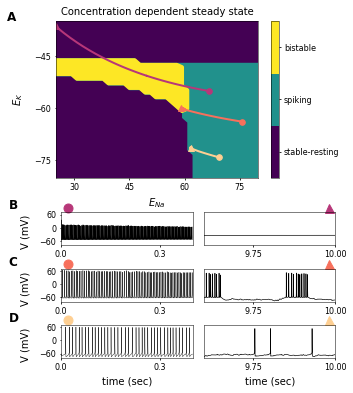

<Figure size 374.4x324 with 0 Axes>

In [28]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.ticker as ticker


ii_t_iapp=3
php_descpt=[]
x_E_Na=[]
x_E_K=[]
for ii_neurons in range(n_neurons):
    if len(a_un[ii_neurons])==len(t_I_app_specf):
        Na_i=m_discrete_pars_vectfield[0][ii_neurons]
        x_E_Na.append(R*T/F*np.log(Na_o/Na_i))
        K_o=m_discrete_pars_vectfield[1][ii_neurons]
        x_E_K.append(R*T/F*np.log(K_o/K_i))
        ###### descpt=0 Uni-stable-silent: means that there is one one stable fixed point on the phase phase Plane
        ###### descpt=1 Uni-stable-spiking: means that there is one one stable orbit on phase Plane
        ###### descpt=2 Bi-stable: means that there is a stable fixed point and a stable orbit on phase Plane
        if a_lc[ii_neurons][ii_t_iapp]==0.0 and a_sn[ii_neurons][ii_t_iapp]>0.0:
            descpt=0
        if a_lc[ii_neurons][ii_t_iapp]>0.0 and a_sn[ii_neurons][ii_t_iapp]==0.0:
            descpt=1
        if a_lc[ii_neurons][ii_t_iapp]>0.0 and a_sn[ii_neurons][ii_t_iapp]>0.0:
            descpt=2
        if a_lc[ii_neurons][ii_t_iapp]==0.0 and a_sn[ii_neurons][ii_t_iapp]==0.0:
            descpt=np.nan
        php_descpt.append(descpt)
    else:
        x_E_Na.append(np.nan)
        x_E_K.append(np.nan)
        php_descpt.append(np.nan)




sigma_v=[n_amp,0.0,0.0,0.0,0.0,0.0,0.0]
        


n_splts=int(len(v_ini_v)/4)
n_splts=3

fig = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.4))

col_num=58
fact_nsplts=10
width_nsplts=7

ax_st=[]
ax_fn=[]
for ii_ini in range(len(v_ini_v[::int(len(v_ini_v)/n_splts)])):
    if ii_ini>0:
        ax_st.append(plt.subplot2grid((fact_nsplts*(n_splts)+31,col_num-3), (ii_ini*fact_nsplts+34,2+1), colspan=int(col_num/2-4),rowspan=width_nsplts-1,sharex=ax_st[0],sharey=ax_st[0]))
        ax_fn.append(plt.subplot2grid((fact_nsplts*(n_splts)+31,col_num-3), (ii_ini*fact_nsplts+34,2+int(col_num/2-1)), colspan=int(col_num/2-4),rowspan=width_nsplts-1,sharex=ax_fn[0],sharey=ax_st[0]))

    else:
        ax_st.append(plt.subplot2grid((fact_nsplts*(n_splts)+31,col_num-3), (ii_ini*fact_nsplts+34,2+1), colspan=int(col_num/2-4),rowspan=width_nsplts-1))
        ax_fn.append(plt.subplot2grid((fact_nsplts*(n_splts)+31,col_num-3), (ii_ini*fact_nsplts+34,2+int(col_num/2-1)), colspan=int(col_num/2-4),rowspan=width_nsplts-1,sharey=ax_st[0]))



## Summary continuation..
axpl = plt.subplot2grid((fact_nsplts*(n_splts)+31,col_num-3), (0, 2), colspan=int(col_num/1.2),rowspan=8+int(fact_nsplts*(n_splts)/1.5))





axpl.set_xlabel(r'$E_{Na}$')
axpl.set_ylabel(r'$E_K$')
axpl.set_title('Concentration dependent steady state')
cmap2=matplotlib.cm.get_cmap('viridis')
bounds2 = [-0.5,0.5,1.5, 2.5]
norm2 = matplotlib.colors.BoundaryNorm(bounds2, cmap2.N)
TICKS2 = [0,1,2]
p = axpl.scatter(x_E_Na, x_E_K,c=np.array(php_descpt), cmap=cmap2, s=50*(1.5**2),marker='s',rasterized=True)

## Making the figure nicer..
axpl.fill_between(xhf,min(x_E_K),yhf,facecolor=p.to_rgba(1))
axpl.fill_betweenx(ylc,min(xlc),xlc,facecolor=p.to_rgba(0))
axpl.fill_between(xhf,yhf,max(x_E_K),facecolor=p.to_rgba(0))
axpl.fill_betweenx(yb,min(xb),xb,facecolor=p.to_rgba(2))
axpl.plot(xb,yb,color=p.to_rgba(2),linewidth=4)

cb0=plt.colorbar(p, cmap=cmap2, norm=norm2, boundaries=bounds2, ticks=TICKS2)
cb0.set_ticklabels(['stable-resting','spiking','bistable'])

cmap=plt.get_cmap('magma')
colors=iter(cmap(np.linspace(1,0,n_splts*2+5)))

ms_sm=9
ms_pr=5.6

ii_ini=n_splts-1
locatorx11=[]
locatorx22=[]
locatory11=[]
for ii_inis in [2,4,5]:
    v_ini=v_ini_v[ii_inis]
    K_o_ini=K_o_ini_v[ii_inis]
    Na_i_ini=Na_i_ini_v[ii_inis]
    colorii=next(colors)
    colorii=next(colors)
    
    file_n='Trace_'+s_model_abrev+'_Imean_'+str(abs(int(n_mean)))+'_Iamp_'+str(abs(int(n_amp)))+'_Nai0_'+str(Na_i_ini)+'_Ki0_'+str(K_i_ini)+'_Ko0_'+str(K_o_ini)+'_data_'+'replicating2020_origPars_v2remim_'+remim_str  

    if os.path.isfile(dir_folder+file_n+'.pkl'):
        with open(dir_folder+file_n+'.pkl', 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            d_save_sim_ii = u.load()

        if len (d_save_sim_ii['v_sim_Nernst'])==0:
            RTF=d_save_sim_ii['d_parameters']['R']*d_save_sim_ii['d_parameters']['T']/d_save_sim_ii['d_parameters']['F']
            Na_o=d_save_sim_ii['d_parameters']['Na_o']
            Na_v=d_save_sim_ii['v_sim_state_vars'][[ii for ii in range(len(d_save_sim_ii['s_sim_state_vars'])) if d_save_sim_ii['s_sim_state_vars'][ii]=='Na_i'][0]]
            Ko_v=d_save_sim_ii['v_sim_state_vars'][[ii for ii in range(len(d_save_sim_ii['s_sim_state_vars'])) if d_save_sim_ii['s_sim_state_vars'][ii]=='K_o'][0]]
            Ki_v=d_save_sim_ii['v_sim_state_vars'][[ii for ii in range(len(d_save_sim_ii['s_sim_state_vars'])) if d_save_sim_ii['s_sim_state_vars'][ii]=='K_i'][0]]
            x_E_Na_v=RTF*np.log(Na_o/Na_v)
            x_E_K_v=RTF*np.log(Ko_v/Ki_v)
        else:
            x_E_K_v=d_save_sim_ii['v_sim_Nernst'][[ii for ii in range(len(d_save_sim_ii['s_sim_Nernst'])) if d_save_sim_ii['s_sim_Nernst'][ii]=='E_K'][0]]
            x_E_Na_v=d_save_sim_ii['v_sim_Nernst'][[ii for ii in range(len(d_save_sim_ii['s_sim_Nernst'])) if d_save_sim_ii['s_sim_Nernst'][ii]=='E_Na'][0]]

        kv=x_E_K_v[::10][:-1]
        nav=x_E_Na_v[::10][:-1]
        print('Ek='+str(kv[0])+' and ENa='+str(nav[0]))
        
        dk=kv[1:]-kv[:-1]
        dna=nav[1:]-nav[:-1]

#         axpl.quiver(nav[::5][nav[::5]>min(x_E_Na)], kv[::5][nav[::5]>min(x_E_Na)], dk[::5][nav[::5]>min(x_E_Na)], dna[::5][nav[::5]>min(x_E_Na)],color=colorii, scale_units='xy', angles='xy', scale=0.5, rasterized=True)
        axpl.plot(nav[::5][nav[::5]>min(x_E_Na)], kv[::5][nav[::5]>min(x_E_Na)],color=colorii)
        tv=d_save_sim_ii['v_sim_state_vars'][[ii for ii in range(len(d_save_sim_ii['s_sim_state_vars'])) if d_save_sim_ii['s_sim_state_vars'][ii]=='t'][0]]
        x_v=d_save_sim_ii['v_sim_state_vars'][[ii for ii in range(len(d_save_sim_ii['s_sim_state_vars'])) if d_save_sim_ii['s_sim_state_vars'][ii]=='v'][0]]

        tst=400.0
        tbound=tv[-1]
        tfn=tv[-1]-tst
        dt=0
        
        
        if min(x_E_Na)>min(x_E_Na_v):
            tbound=tv[x_E_Na_v<min(x_E_Na)][0]
            tfn=tbound-tst
            dt=tv[-1]-tbound
            
        axpl.plot(x_E_Na_v[0],x_E_K_v[0],'o',markersize=ms_pr,color=colorii)
        axpl.plot(x_E_Na_v[(tv>=tfn)*(tv<=tbound)][-1],x_E_K_v[(tv>=tfn)*(tv<=tbound)][-1],'^',markersize=ms_pr,color=colorii)
        
        ax_st[ii_ini].plot(tv[tv<=tst]/1000.0,x_v[tv<=tst],color='k', linewidth=matplotlib.rcParams['lines.linewidth']*0.2)
        ax_st[ii_ini].plot((tv[tv<=tst][0]+20)/1000.0,92,'o',markersize=ms_sm,color=colorii,clip_on=False)
        ax_st[ii_ini].set_xlim([min(tv[tv<=tst])/1000.0,max(tv[tv<=tst])/1000.0])
        ax_st[ii_ini].set_ylim([-79,105])
        
        locatorx11.append(ticker.MaxNLocator(nbins=1)) # with 3 bins you will have 4 ticks
        ax_st[ii_ini].xaxis.set_major_locator(locatorx11[-1])

        locatory11.append(ticker.MaxNLocator(nbins=1)) # with 3 bins you will have 4 ticks
        ax_st[ii_ini].yaxis.set_major_locator(locatory11[-1])

        
        ax_fn[ii_ini].plot((tv[(tv>=tfn)*(tv<=tbound)]+dt)/1000.0,x_v[(tv>=tfn)*(tv<=tbound)],color='k', linewidth=matplotlib.rcParams['lines.linewidth']/3)
        ax_fn[ii_ini].plot((tv[(tv>=tfn)*(tv<=tbound)][-1]+dt-20)/1000.0,92,'^',markersize=ms_sm,color=colorii,clip_on=False)
        ax_fn[ii_ini].set_xlim([min(tv[(tv>=tfn)*(tv<=tbound)]+dt)/1000.0,max(tv[(tv>=tfn)*(tv<=tbound)]+dt)/1000.0])
        ax_fn[ii_ini].set_ylim([-79,70])
        
        locatorx22.append(ticker.MaxNLocator(nbins=1))
        ax_fn[ii_ini].xaxis.set_major_locator(locatorx22[-1])
        
        ax_fn[ii_ini].get_yaxis().set_visible(False)
        ii_ini-=1
    else:
        print(file_n+'  Doesnt exist...' )

# axpl.set_xlim([min(x_E_Na),max(x_E_Na)])
# axpl.set_ylim([min(x_E_K),max(x_E_K)]) 

axpl.set_xlim([min(x_E_Na),80])
axpl.set_ylim([-80,max(x_E_K)])

locatorypl=ticker.MaxNLocator(nbins=4)
axpl.yaxis.set_major_locator(locatorypl)

locatorxpl=ticker.MaxNLocator(nbins=4)
axpl.xaxis.set_major_locator(locatorxpl)
            
ax_fn[-1].set_xlabel('time (sec)')
ax_st[-1].set_xlabel('time (sec)')

ax_st[0].set_ylabel('V (mV)')
ax_st[1].set_ylabel('V (mV)')
ax_st[2].set_ylabel('V (mV)')

print('I_app='+str(t_I_app_specf[ii_t_iapp]))

############################################
### Aligning y labels
############################################

ax=np.concatenate([[axpl],ax_st])

labely = -0.15  # axes coords
ax[0].yaxis.set_label_coords(labely, 0.5)

### When axes are not exactly the same size.. this is necessary
boxpl =axpl.get_position()
box0st =ax_st[0].get_position()
box1st =ax_st[1].get_position()
box2st =ax_st[2].get_position()

ax_st[0].yaxis.set_label_coords(boxpl.width/box0st.width*labely, 0.4)
ax_st[1].yaxis.set_label_coords(boxpl.width/box1st.width*labely, 0.4)
ax_st[2].yaxis.set_label_coords(boxpl.width/box2st.width*labely, 0.4)

############################################
####### Placing panel labels #############3#
############################################

ax=np.concatenate([[axpl],ax_st])

import string
for n, axs in enumerate(ax):
    if n==0:
        axs.text(-0.24, 1.0, string.ascii_uppercase[n], transform=axs.transAxes, 
                size=12, fontweight='bold')
    else:
        axs.text(-0.4, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, 
                size=12, fontweight='bold')



fig_name='Nernst_plane_andTraces_'+s_model_abrev+'_Imean_'+str(abs(int(n_mean)))+'_Iamp_'+str(abs(int(n_amp)))+'_Nai0_'+str(Na_i_ini)+'_Ki0_'+str(K_i_ini)+'_Ko0_'+str(K_o_ini)+'_data_'+'replicating2020_origPars' 
md_dir={}
md_dir['Title']='Nernst plane and example trajectories'+s_model_abrev
md_dir['Author']= 'Susana Contreras, 10.07.90'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'


fig.savefig('./Figs/'+'Fig_7.eps',dpi=300)
fig.savefig('./Figs/'+'Fig_7.tif',dpi=300)
saving_pdf_figure(fig,'./Figs/'+fig_name+'_small_',md_dir)

fig.show()

In [29]:
fig_name

'Nernst_plane_andTraces_MTM_W_sPNAs_Temp_proper_correcected_timescale_Imean_1_Iamp_1_Nai0_10.0_Ki0_150.71_Ko0_17.0_data_replicating2020_origPars'